# Fire up graphlab create
(See [Getting Started with SFrames](../Week%201/Getting%20Started%20with%20SFrames.ipynb) for setup instructions)

In [2]:
import graphlab
# Limit number of worker processes. This preserves system memory, which prevents hosted notebooks from crashing.
graphlab.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 4)
graphlab.canvas.set_target('ipynb')

# Load some house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [4]:
sales = graphlab.SFrame('home_data.gl/')
sales.show()

# Exploring the data for housing sales 

The house price is correlated with the number of square feet of living space.

In [23]:
sales.show(view="Scatter Plot", x="sqft_living", y="price")

# Create a simple regression model of sqft_living to price

Split data into training and testing.  
We use seed=0 so that everyone running this notebook gets the same results.  In practice, you may set a random seed (or let GraphLab Create pick a random seed for you).  

In [6]:
train_data,test_data = sales.random_split(.8,seed=0)

## Build the regression model using only sqft_living as a feature

In [7]:
sqft_model = graphlab.linear_regression.create(train_data, target='price', features=['sqft_living'],
                                               validation_set=None)

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.009816     | 4349521.926170     | 262943.613754 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

# Evaluate the simple model

In [8]:
print test_data['price'].mean()
print sqft_model.evaluate(test_data)

543054.042563


RMSE of about \$255,170!

# Let's show what our predictions look like

Matplotlib is a Python plotting library that is also useful for plotting.  You can install it with:

'pip install matplotlib'

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

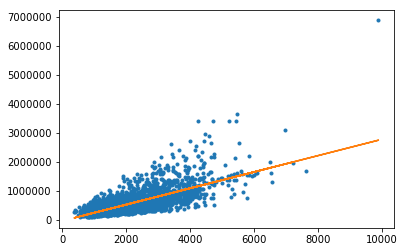

In [11]:
plt.plot(test_data['sqft_living'],test_data['price'],'.',
        test_data['sqft_living'],sqft_model.predict(test_data),'-')

Above:  blue dots are original data, green line is the prediction from the simple regression.

Below: we can view the learned regression coefficients. 

In [12]:
sqft_model.get('coefficients')

name,index,value,stderr
(intercept),None,-47114.0206702,4923.34437753
sqft_living,None,281.957850166,2.16405465323


# Explore other features in the data

To build a more elaborate model, we will explore using more features.

In [13]:
my_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode']
sales[my_features].show()

In [15]:
sales.show(view='BoxWhisker Plot', x='zipcode', y='price')

Pull the bar at the bottom to view more of the data.  

98039 is the most expensive zip code.

# Build a regression model with more features

In [16]:
my_features_model = graphlab.linear_regression.create(train_data,target='price',features=my_features,
                                                      validation_set=None)

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 6

Number of unpacked features : 6

Number of coefficients    : 115

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.027077     | 3763208.270523     | 181908.848367 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

## Comparing the results of the simple model with adding more features

In [18]:
print sqft_model.evaluate(test_data)
print my_features_model.evaluate(test_data)

{'max_error': 4143550.8825285938, 'rmse': 255191.02870527358}
{'max_error': 3486584.509381705, 'rmse': 179542.4333126903}


The RMSE goes down from \$255,170 to \$179,508 with more features.

# Apply learned models to predict prices of 3 houses

The first house we will use is considered an "average" house in Seattle. 

In [19]:
house1 = sales[sales['id']=='5309101200']
house1

In [21]:
print house1['price']
print sqft_model.predict(house1)
print my_features_model.predict(house1)

[620000, ... ]


In this case, the model with more features provides a worse prediction than the simpler model with only 1 feature.  However, on average, the model with more features is better.

## Prediction for a second, fancier house

We will now examine the predictions for a fancier house.

In [24]:
house2 = sales[sales['id']=='1925069082']
house2

In [26]:
print house2['price']
print sqft_model.predict(house2)
print my_features_model.predict(house2)

[1261170.404099968]


In this case, the model with more features provides a better prediction.  This behavior is expected here, because this house is more differentiated by features that go beyond its square feet of living space, especially the fact that it's a waterfront house. 

## Last house, super fancy

Our last house is a very large one owned by a famous Seattleite.

In [28]:
bill_gates = {'bedrooms':[8], 
              'bathrooms':[25], 
              'sqft_living':[50000], 
              'sqft_lot':[225000],
              'floors':[4], 
              'zipcode':['98039'], 
              'condition':[10], 
              'grade':[10],
              'waterfront':[1],
              'view':[4],
              'sqft_above':[37500],
              'sqft_basement':[12500],
              'yr_built':[1994],
              'yr_renovated':[2010],
              'lat':[47.627606],
              'long':[-122.242054],
              'sqft_living15':[5000],
              'sqft_lot15':[40000]}

In [29]:
print my_features_model.predict(graphlab.SFrame(bill_gates))

[13749825.525719076]


The model predicts a price of over $13M for this house! But we expect the house to cost much more.  (There are very few samples in the dataset of houses that are this fancy, so we don't expect the model to capture a perfect prediction here.)

# assignment
### Q1: Selection and summary statistics: 
In the notebook we covered in the module, we discovered which neighborhood (zip code) of Seattle had the highest average house sale price. Now, take the sales data, select only the houses with this zip code, and compute the average price. 

In [13]:
zipcode = sales.groupby(key_columns = 'zipcode', operations = {'avg_per_zip':graphlab.aggregate.AVG('price')})
zipcode.sort('avg_per_zip', ascending=False)

zipcode,avg_per_zip
98039,2160606.6
98004,1355927.09779
98040,1194230.00355
98112,1095499.36803
98102,901258.238095
98109,879623.623853
98105,862825.231441
98006,859684.763052
98119,849448.01087
98005,810164.880952


In [14]:
print max(zipcode['avg_per_zip'])

2160606.6


### Q2: Filtering data: 
One of the key features we used in our model was the number of square feet of living space (‘sqft_living’) in the house. For this part, we are going to use the idea of filtering (selecting) data. In particular, we are going to use logical filters to select rows of an SFrame. You can find more info in the Logical Filter section of this documentation. Using such filters, first select the houses that have ‘sqft_living’ higher than 2000 sqft but no larger than 4000 sqft.What fraction of the all houses have ‘sqft_living’ in this range? 

In [25]:
filtered = sales[sales['sqft_living']>2000]
filtered = filtered[filtered['sqft_living']<=4000]

In [37]:
a = filtered.num_rows()
b = sales.num_rows()
print float(a)/b

0.421875722945


### Q3: Building a regression model with several more features: 
build a model using the following features:  
advanced_features = 
[
'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode',
'condition', # condition of house				
'grade', # measure of quality of construction				
'waterfront', # waterfront property				
'view', # type of view				
'sqft_above', # square feet above ground				
'sqft_basement', # square feet in basement				
'yr_built', # the year built				
'yr_renovated', # the year renovated				
'lat', 'long', # the lat-long of the parcel				
'sqft_living15', # average sq.ft. of 15 nearest neighbors 				
'sqft_lot15', # average lot size of 15 nearest neighbors 
]  
Compute the RMSE (root mean squared error) on the test_data for the model using just my_features, and for the one using advanced_features.

In [40]:
advanced_features = [
'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode',
'condition', # condition of house
'grade', # measure of quality of construction
'waterfront', # waterfront property
'view', # type of view
'sqft_above', # square feet above ground
'sqft_basement', # square feet in basement
'yr_built', # the year built
'yr_renovated', # the year renovated
'lat', 'long', # the lat-long of the parcel
'sqft_living15', # average sq.ft. of 15 nearest neighbors
'sqft_lot15'# average lot size of 15 nearest neighbors 
]

In [41]:
train_data,test_data = sales.random_split(.8,seed=0)
new_model = graphlab.linear_regression.create(train_data,target='price',features=advanced_features,validation_set=None)

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 18

Number of unpacked features : 18

Number of coefficients    : 127

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.082218     | 3469012.450686     | 154580.940736 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [42]:
print new_model.evaluate(test_data)

{'max_error': 3556849.413858208, 'rmse': 156831.1168021901}


In [44]:
179542-156831

22711